In [1]:
from utilities import get_ohlc_data
import pandas as pd
import numpy as np

In [2]:
# Data Sourcing
TICKER = 'GOOG'
tickers = [TICKER]
adjusted_close = get_ohlc_data(tickers, start_date='2020-01-01')
data = pd.DataFrame(adjusted_close[TICKER])
data["Ret1"] = data['Adj Close'].pct_change()
data["FutureReturn"] = data['Ret1'].rolling(40).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
data["Buy"] = data["FutureReturn"] > 0


# Feature Engineering
from technical_indicators import calculate_bollinger_bands, calculate_adx, calculate_rsi, calculate_rolling_std, calculate_rolling_mean
from itertools import product
for func, window in product([calculate_bollinger_bands,calculate_rsi,calculate_adx, calculate_rolling_std, ], [40,80,120]):
    series = func(data, window)
    data[series.name] = series
data.dropna(inplace=True)
data.drop(['Ret1', 'FutureReturn', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Deep Learning Model
import tensorflow as tf

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True,
)

tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(142)  # We will set a random seed so that results obtained are somewhat replicable

act_fun = "relu" # Activation function
hp_units = 25 # Number of units in the first layer
hp_units_2 = 15 # Number of units in the second layer
hp_units_3 = 10 # Number of units in the third layer
n_dropout = 0.2 # Dropout rate

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

hp_lr = 1e-5  # Learning rate

adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [4]:
from preprocessing import encode_labels, train_test_split
DATA = encode_labels(data, ['Buy'])
DATA = encode_labels(data, [column for column in data.columns if column.startswith('Bollinger')])
DATA = train_test_split(DATA, test_size=0.2, y_name='Buy')
history = model.fit(
    DATA.x_train,
    DATA.y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=12,
    verbose=2,
    callbacks=[es],

)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

y_prob = model.predict(DATA.x_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(DATA.x_test, DATA.y_test)
print("Model accuracy in test: ", acc)

Epoch 1/500


43/43 - 1s - loss: 12.0656 - accuracy: 0.4252 - val_loss: 7.3115 - val_accuracy: 0.1085 - 1s/epoch - 30ms/step
Epoch 2/500
43/43 - 0s - loss: 12.0071 - accuracy: 0.4544 - val_loss: 6.8543 - val_accuracy: 0.1008 - 78ms/epoch - 2ms/step
Epoch 3/500
43/43 - 0s - loss: 11.6474 - accuracy: 0.4505 - val_loss: 6.4761 - val_accuracy: 0.1008 - 75ms/epoch - 2ms/step
Epoch 4/500
43/43 - 0s - loss: 10.6366 - accuracy: 0.4641 - val_loss: 6.0169 - val_accuracy: 0.1163 - 74ms/epoch - 2ms/step
Epoch 5/500
43/43 - 0s - loss: 11.8381 - accuracy: 0.4718 - val_loss: 5.7899 - val_accuracy: 0.1318 - 86ms/epoch - 2ms/step
Epoch 6/500
43/43 - 0s - loss: 10.6909 - accuracy: 0.4621 - val_loss: 5.3615 - val_accuracy: 0.1163 - 74ms/epoch - 2ms/step
Epoch 7/500
43/43 - 0s - loss: 10.9752 - accuracy: 0.4718 - val_loss: 5.0418 - val_accuracy: 0.1008 - 73ms/epoch - 2ms/step
Epoch 8/500
43/43 - 0s - loss: 10.8464 - accuracy: 0.4757 - val_loss: 4.7227 - val_accuracy: 0.0930 - 74ms/epoch - 2ms/step
Epoch 9

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0])

## Data Visualisation

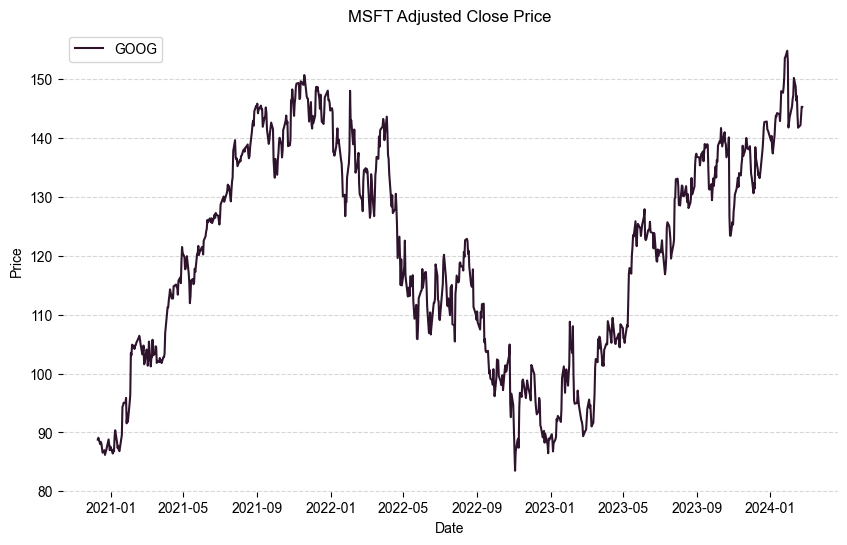

In [60]:
from visualisation import plot_smooth_multiline_chart, plot_acf_pacf_side_by_side
plot_smooth_multiline_chart(data=[(data['Close'].index,data['Close'], 'GOOG')], title='MSFT Adjusted Close Price', x_label='Date',y_label='Price').show()

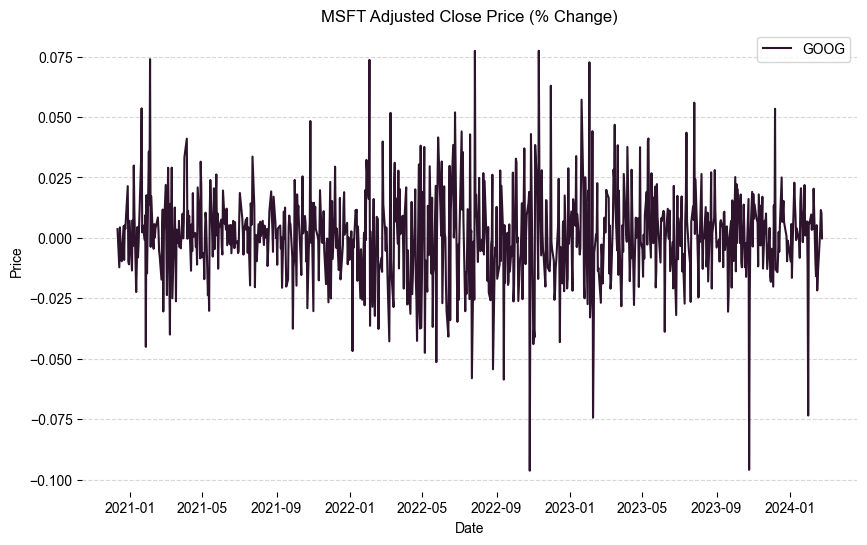

In [61]:
plot_smooth_multiline_chart(data=[(data['Close'].index,data['Close'].pct_change(), 'GOOG')], title='MSFT Adjusted Close Price (% Change)', x_label='Date', y_label='Price').show()

C:\Users\kumar\AppData\Local\Temp\ipykernel_17560\4239797791.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_acf_pacf_side_by_side(data['Close'], lags=50, title='ACF and PACF (GOOG Prices)').show()


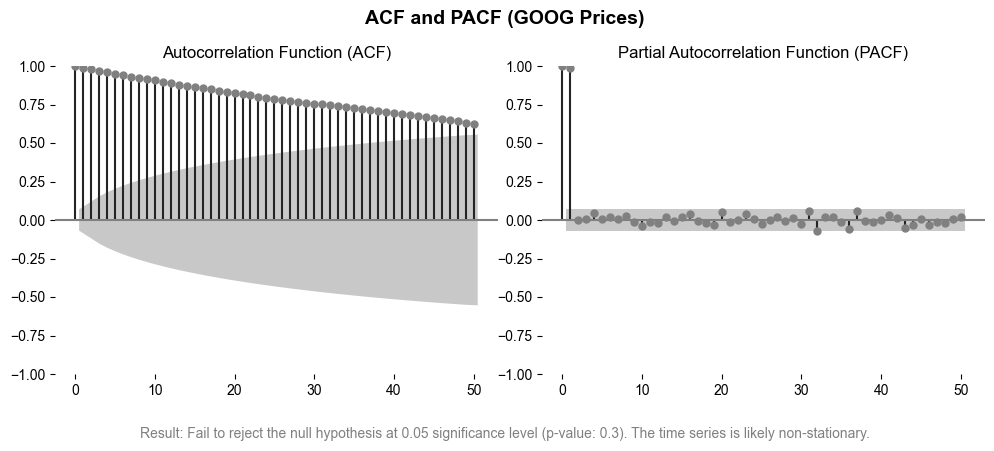

In [62]:
plot_acf_pacf_side_by_side(data['Close'], lags=50, title='ACF and PACF (GOOG Prices)').show()

C:\Users\kumar\AppData\Local\Temp\ipykernel_17560\4211428362.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_acf_pacf_side_by_side(data['Close'].pct_change()[1:], lags=50, title='ACF and PACF (GOOG Price % Change)').show()


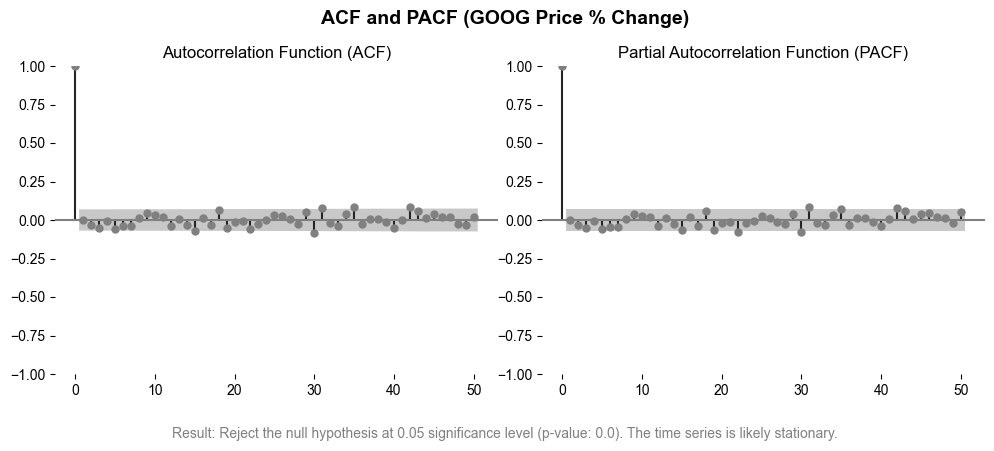

In [63]:
plot_acf_pacf_side_by_side(data['Close'].pct_change()[1:], lags=50, title='ACF and PACF (GOOG Price % Change)').show()

==================  ==========
Confusion Matrix        Values
==================  ==========
True Positives      120
True Negatives        1
False Positives      31
False Negatives       9
Accuracy              0.751553
Precision             0.794702
Recall                0.930233
==================  ==========


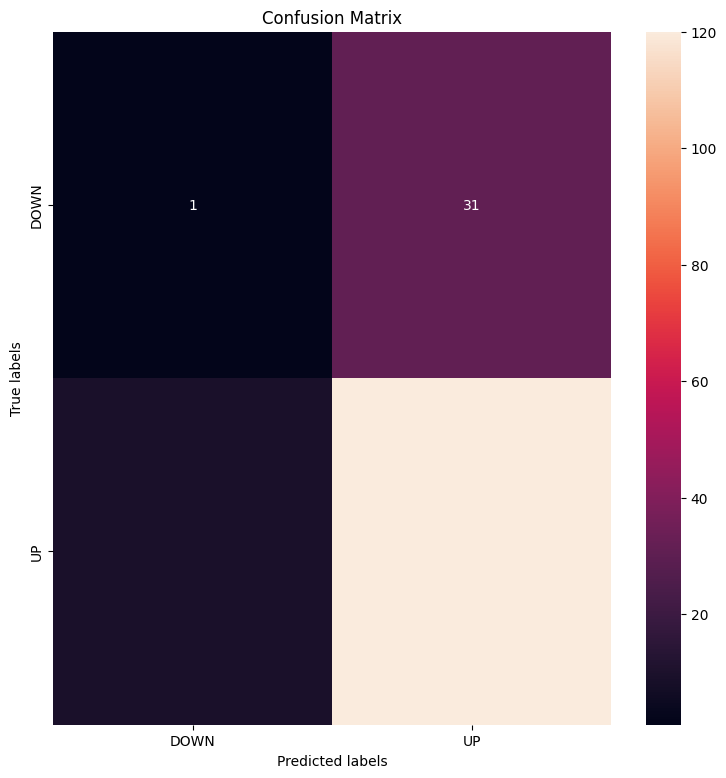

In [5]:
cm = metrics.confusion_matrix(DATA.y_test, y_pred.flatten())
plt.figure(figsize=(9, 9))

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
# annot=True to annotate cells, ftm='g'
#  to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["DOWN", "UP"])
ax.yaxis.set_ticklabels(["DOWN", "UP"]);

from tabulate import tabulate
accuracy = lambda cm: (cm[0, 0] + cm[1, 1]) / cm.sum()
precision = lambda cm: cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = lambda cm: cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = lambda cm: 2 * (precision(cm) * recall(cm)) / (precision(cm) + recall(cm))
print(tabulate([['True Positives', cm[1, 1]], ['True Negatives', cm[0, 0]], ['False Positives', cm[0, 1]], ['False Negatives', cm[1, 0]], ['Accuracy', accuracy(cm)], ['Precision', precision(cm)], ['Recall', recall(cm)]], headers=['Confusion Matrix', 'Values'], tablefmt='rst'))